In [5]:
!pip3 install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------  10.7/11.0 MB 61.0 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 57.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   -- ------------------------------------- 3.1/44.5 MB 14.2 MB/s eta 0:00:03
   -------------- ------------------------- 16.0/44.5 MB 37.3 MB/s eta 0:00:01
   ------------------------------------ --- 40.6/44.5 MB 64.6 MB/s eta 0:00:01
   ---------------------------------------- 44.5/44.5 MB 63.0 MB/s eta 0:00:00


In [1]:
import math


class Perceptron(object):
    def __init__(self, weights, bias=0):
        self.weight = weights
        self.bias = bias
        #self.activation
    
    def calc_activity(self, inputs):
        activity = self.bias
        for i, inp in enumerate(inputs):
            activity = activity + inp*self.weight[i]
        return activity
    
    def calc_activation(self, inputs):
        return 1 / (1 + math.exp(-self.calc_activity(inputs)))
    
    def print(self):
        print("weights: ", self.weight)
        print("bias:    ", self.bias)
        
    def train_once(self, inputs, target, eta, train_bias=False):
        newWeights = []
        activation = self.calc_activation(inputs)
        error = target - activation
        delta = -error * (1 - activation) * activation
        
        for i, weight in enumerate(self.weight):
            newWeights.append(weight - eta * delta * inputs[i])
            
        if train_bias:
            self.bias = self.bias - eta * delta
        self.weight = newWeights
        
        return self.calc_activation(inputs)

In [2]:
class Layer(object):
    def __init__(self, perceptrons, previous=None, following=None):
        self.perc = perceptrons
        self.previous = previous
        self.following = following
        
        
def feed_forward(out, inputs):
    hidden = out.previous.perc
    hiddenAct = []
    for perceptron in hidden:
        hiddenAct.append(perceptron.calc_activation(inputs))
    
    return out.perc[0].calc_activation(hiddenAct)

    
def ffbp_epoch(out, inputs, target, eta, train_bias=False):
    #FEED FORWARD
    hidden = out.previous.perc
    hiddenAct = []
    for j, perceptron in enumerate(hidden):
        hiddenAct.append(perceptron.calc_activation(inputs))
    
    y = out.perc[0].calc_activation(hiddenAct)
    error = target - y
    delta_k = error * (1 - y) * y
    
    #BACK PROPAGATION
    #k is index of output layer (only 1 in this case)
    newWeights_k = []
    for i, weight in enumerate(out.perc[0].weight):
        newWeights_k.append(weight + eta * delta_k * hiddenAct[i])
    newBias_k = out.perc[0].bias + eta * delta_k
    #BUT DON'T UPDATE YET!
    
    #j is index of hidden layer
    delta_j = []
    newWeights_j = []
    for j, perceptron in enumerate(hidden):
        sum_dkw = delta_k * out.perc[0].weight[j] #This sum is for all of k. Right now it's only 1, but if I had multiple outputs, it would be delta * weight of each of them.
        delta_j.append((1 - hiddenAct[j]) * hiddenAct[j] * sum_dkw)
        
        #i is the index of input
        newWeights_j.append([])
        for i, weight in enumerate(perceptron.weight):
            newWeights_j[j].append(weight + eta * delta_j[j] * inputs[i])
        
        hidden[j].weight = newWeights_j[j]
        if train_bias:
            hidden[j].bias = hidden[j].bias + eta * delta_j[j]
        #print("hidden ", j, " output: ", hidden[j].calc_activation(inputs))
    
    out.perc[0].weight = newWeights_k
    if train_bias:
        out.perc[0].bias = newBias_k
    
    return out

[-0.01907456 -0.56358202  0.43776111  0.48947915] [-0.50676867  0.38722037]
Best Threshold: 0.48484848484848486, Best Accuracy: 0.7


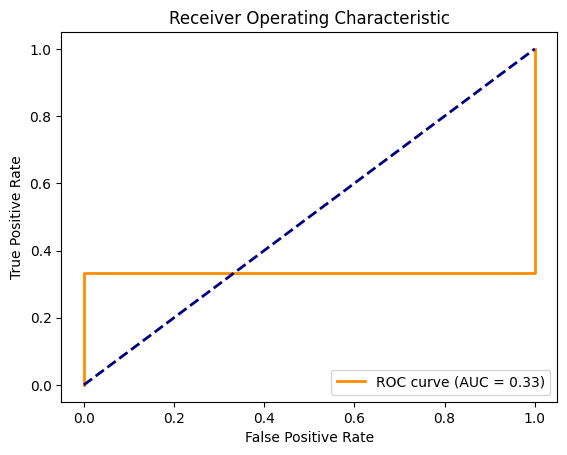

In [28]:
import numpy as np
import random
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def online_once(outLayer, inputs, targetOutputs, eta):
    for i, inp in enumerate(inputs):
        outLayer = ffbp_epoch(outLayer, inp, targetOutputs[i], eta)
    return outLayer


# Load the data
data = np.array([[0.90, 0.87],
                 [1.81, 1.02],
                 [1.31, 0.75],
                 [2.36, 1.60],
                 [2.48, 1.14],
                 [2.17, 2.08],
                 [0.41, 1.87],
                 [2.85, 2.91],
                 [2.45, 0.52],
                 [1.05, 1.93],
                 [2.54, 2.97],
                 [2.32, 1.73],
                 [0.07, 0.09],
                 [1.86, 1.31],
                 [1.32, 1.96],
                 [1.45, 2.19],
                 [0.94, 0.34],
                 [0.28, 0.71],
                 [1.75, 2.21],
                 [2.49, 1.52]])
taca = np.array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0])

X_train = data[::2]
y_train = taca[::2]
X_test = data[1::2]
y_test = taca[1::2]

n = 2
# calculate the range for the weights
lower, upper = -(1.0 / np.sqrt(n)), (1.0 / np.sqrt(n))
# generate random numbers
input_weights = np.random.rand(4)
input_weights_scaled = lower + input_weights * (upper - lower)
m = 2
lower, upper = -(1.0 / np.sqrt(m)), (1.0 / np.sqrt(m))
output_weights = np.random.rand(2)
output_weights_scaled =  lower + output_weights * (upper - lower)

print(input_weights_scaled, output_weights_scaled)

# Initialize perceptron
hidden = Layer([Perceptron([input_weights_scaled[0], input_weights_scaled[1]]), Perceptron([input_weights_scaled[2], input_weights_scaled[3]])])
output = Layer([Perceptron([output_weights_scaled[0], output_weights_scaled[1]])], hidden)
hidden.follow = output

# Training the network
eta = 0.5
for epoch in range(30):
    output = online_once(output, X_train, y_train, eta)

# Optimize threshold
thresholds = np.linspace(0, 1, 100)
best_threshold = 0
best_accuracy = 0
predictions = [feed_forward(output, x) for x in X_test]

for thresh in thresholds:
    preds = [1 if p >= thresh else 0 for p in predictions]
    accuracy = np.mean([pred == true for pred, true in zip(preds, y_test)])
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = thresh

print(f"Best Threshold: {best_threshold}, Best Accuracy: {best_accuracy}")

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()